<a href="https://colab.research.google.com/github/LM1997610/Fundamentals_DataScience/blob/main/Ex2_AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 32 * 32 * 3
num_classes = 10

hidden_size = [50]
num_epochs = 10
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.95
reg = 0.001
num_training = 49000
num_validation = 1000
train = True


In [3]:
#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------
norm_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                           train=True,
                                           transform=norm_transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                          train=False,
                                          transform=norm_transform)

#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)
print()
print(" train_dataset: {}\n val_dataset: {}\n test_dataset: {}".format(len(train_dataset),
                                                                       len(val_dataset),
                                                                       len(test_dataset)))

Files already downloaded and verified

 train_dataset: 49000
 val_dataset: 1000
 test_dataset: 10000


In [4]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

#--------------------------------

Using device: cpu


In [5]:
from os import XATTR_CREATE
#======================================================================================
# Q4: Implementing multi-layer perceptron in PyTorch
#======================================================================================
# So far we have implemented a two-layer network using numpy by explicitly
# writing down the forward computation and deriving and implementing the
# equations for backward computation. This process can be tedious to extend to
# large network architectures
#
# Popular deep-learning libraries like PyTorch and Tensorflow allow us to
# quickly implement complicated neural network architectures. They provide
# pre-defined layers which can be used as building blocks to define our
# network. They also enable automatic-differentiation, which allows us to
# define only the forward pass and let the libraries perform back-propagation
# using automatic differentiation.
#
# In this question we will implement a multi-layer perceptron using the PyTorch
# library.  Please complete the code for the MultiLayerPerceptron, training and
# evaluating the model. Once you can train the two layer model, experiment with
# adding more layers and report your observations
#--------------------------------------------------------------------------------------

#-------------------------------------------------
# Fully connected neural network with one hidden layer
#-------------------------------------------------

class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, hidden_layers, num_classes):

        super(MultiLayerPerceptron, self).__init__()

        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.num_classes = num_classes

        #Use the layers list to store a variable number of layers

        layers = [nn.Linear(self.input_size, self.hidden_layers), # ReLu activation in forward pass
                  nn.Linear(self.hidden_layers,self.num_classes)]



        # Enter the layers into nn.Sequential, so the model may "see" them
        # Note the use of * in front of layers

        self.layers = nn.Sequential(*layers)

    def forward(self, x):

        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        # Note that you do not need to use the softmax operation at the end.            #
        # Softmax is only required for the loss computation and the criterion used below#
        # nn.CrossEntropyLoss() already integrates the softmax and the log loss together#
        #################################################################################

        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        x = x.reshape(-1,32*32*3)
        out = F.relu(self.layers[0](x))
        out = self.layers[1](out)


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return out


In [6]:
model = MultiLayerPerceptron(input_size, hidden_size[0], num_classes).to(device)

In [7]:
print("Model's state_dict:")

for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
layers.0.weight 	 torch.Size([50, 3072])
layers.0.bias 	 torch.Size([50])
layers.1.weight 	 torch.Size([10, 50])
layers.1.bias 	 torch.Size([10])


In [13]:
if train:

    loss_history = []
    model.apply(weights_init)
    model.train() #set dropout and batch normalization layers to training mode

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

    # Train the model
    lr = learning_rate
    total_step = len(train_loader)



    for epoch in tqdm(range(num_epochs)):
        for i, (images, labels) in enumerate(train_loader):

            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            #################################################################################
            # TODO: Implement the training code                                             #
            # 1. Pass the images to the model                                               #
            # 2. Compute the loss using the output and the labels.                          #
            # 3. Compute gradients and update the model using the optimizer                 #
            # Use examples in https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
            #################################################################################

            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


            output = model(images)
            loss = criterion(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if (i+1) % 100 == 0:

                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1,
                                                                          num_epochs,
                                                                          i+1,
                                                                          total_step,
                                                                          loss.item()))
        loss_history.append(loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Step [100/245], Loss: 1.7087
Epoch [1/10], Step [200/245], Loss: 1.6535
Epoch [2/10], Step [100/245], Loss: 1.5903
Epoch [2/10], Step [200/245], Loss: 1.5776
Epoch [3/10], Step [100/245], Loss: 1.5727
Epoch [3/10], Step [200/245], Loss: 1.4773
Epoch [4/10], Step [100/245], Loss: 1.3917
Epoch [4/10], Step [200/245], Loss: 1.3636
Epoch [5/10], Step [100/245], Loss: 1.3931
Epoch [5/10], Step [200/245], Loss: 1.4034
Epoch [6/10], Step [100/245], Loss: 1.5264
Epoch [6/10], Step [200/245], Loss: 1.3952
Epoch [7/10], Step [100/245], Loss: 1.3114
Epoch [7/10], Step [200/245], Loss: 1.3927
Epoch [8/10], Step [100/245], Loss: 1.3820
Epoch [8/10], Step [200/245], Loss: 1.2792
Epoch [9/10], Step [100/245], Loss: 1.3273
Epoch [9/10], Step [200/245], Loss: 1.2535
Epoch [10/10], Step [100/245], Loss: 1.4441
Epoch [10/10], Step [200/245], Loss: 1.3777


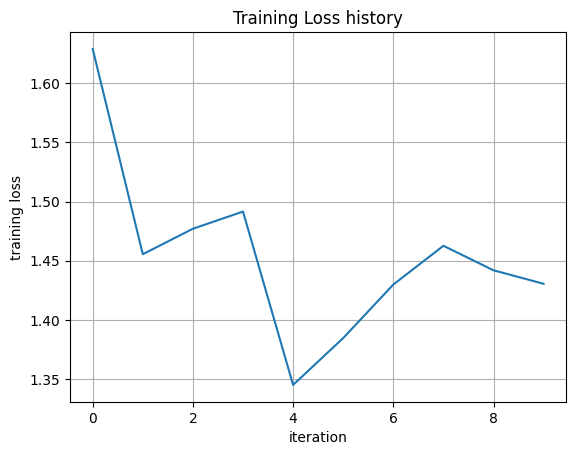

In [14]:
plt.figure(1)
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.grid()
plt.show()

In [ ]:
# Code to update the lr
lr *= learning_rate_decay
update_lr(optimizer, lr)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(val_loader):

        images = images.to(device)
        labels = labels.to(device)
        ####################################################
        # TODO: Implement the evaluation code              #
        # 1. Pass the images to the model                  #
        # 2. Get the most confident predicted class        #
        ####################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        output= model(images)
        _ , predicted = torch.max(output, 1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('\nValidataion accuracy is: {} %'.format(100 * correct / total))

In [ ]:
#else:
    # Run the test code once you have your by setting train flag to false
    # and loading the best model

#best_model = None
#best_model = torch.load('model.ckpt')
#best_model = model

#model.load_state_dict(best_model)

# Test the model
model.eval() #set dropout and batch normalization layers to evaluation mode

# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)

        ####################################################
        # TODO: Implement the evaluation code              #
        # 1. Pass the images to the model                  #
        # 2. Get the most confident predicted class        #
        ####################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


        output= model(images)
        _ , predicted = torch.max(output, 1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

